# Notebook to plot power spectra and CF for the halos and cdm

## Loading packages

In [43]:
import numpy as np
# import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 16).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from sympy import symbols, Eq, solve



## Nested dictionary

In [44]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(5, list)
pow_gev = nested_dict(2, list)
class_data = nested_dict(3, list)
rsd_coeff = nested_dict(2, list)
bias_halo = nested_dict(2, list)
bias_halo_lin = nested_dict(2, list)
rsd_coeff_halo = nested_dict(2, list)
f_gr_data =nested_dict(2, list)

## Weighted power log, linear and every N point

In [49]:
def wighted_power(k_w, Pk, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip, string):
    if (string=="log"):
        print("method:",string)
        du  = (np.log10(kmax)-np.log10(kmin) )/number_binning;
        weight_pow=np.zeros((number_binning,3));
        k = kmin;
        for i in range(number_binning):
            k = k * 10** (du);
            dk = k * (10** (du) -1.0);
            for j in range (np.int(np.shape(k_w)[0])):
                if(k_w[j]>k-dk/2. and k_w[j]<k+dk/2. and k_w[j]<(k_w.max())/nyqvist_skip and j> 1*cosmicvar_skip ):
                    weight_pow[i,0] = weight_pow[i,0] + k_w[j] * count_arr[j]; # To correct the k based on the weights
                    weight_pow[i,1] = weight_pow[i,1] + Pk[j] * count_arr[j];
                    weight_pow[i,2] = weight_pow[i,2] + count_arr[j];

            if (weight_pow[i,1] !=0):
                weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,2]
                weight_pow[i,1] =weight_pow[i,1]/weight_pow[i,2];
            else:
                weight_pow[i,1] =weight_pow[i,1];
    if (string=="lin"):
        print("method:",string)
        dk  = (kmax-kmin)/number_binning;
        weight_pow=np.zeros((number_binning,3));
        k = kmin;
        for i in range(number_binning):
            k = k + dk;
            for j in range (np.int(np.shape(k_w)[0])):
                if(k_w[j]>k-dk/2. and k_w[j]<k+dk/2. and k_w[j]<(k_w.max())/nyqvist_skip and j> 1*cosmicvar_skip ):
                    weight_pow[i,0] = weight_pow[i,0] + k_w[j] * count_arr[j]; # To correct the k based on the weights
                    weight_pow[i,1] = weight_pow[i,1] + Pk[j] * count_arr[j];# To correct the Pk based on the weights
                    weight_pow[i,2] = weight_pow[i,2] + count_arr[j];

            if (weight_pow[i,1] !=0):
                weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,2]
                weight_pow[i,1] = weight_pow[i,1]/weight_pow[i,2];
            else:
                weight_pow[i,1] =weight_pow[i,1];
                
    if (string=="every_N_point"):
        # number_binning is actually how many points to collect
        print("method:",string)
        number_modes  = np.int(np.shape(k_w)[0]/number_binning);
        weight_pow=np.zeros((number_modes,5));
        
        for i in range(number_modes):
            for j in range (number_binning):
                weight_pow[i,0] = weight_pow[i,0] + k_w[i*number_binning+j]* count_arr[i*number_binning+j]; # To correct the k based on the weights
                weight_pow[i,1] = weight_pow[i,1] + Pk[i*number_binning+j] * count_arr[i*number_binning+j];# To correct the Pk based on the weights
                weight_pow[i,4] = weight_pow[i,4] + count_arr[i*number_binning+j];                 
            weight_pow[i,0] = weight_pow[i,0]/weight_pow[i,4] #mean of k
            weight_pow[i,1] = weight_pow[i,1]/weight_pow[i,4];# mean of P
            for j in range (number_binning):
                #S^2 =  \frac{\Sigma_i N_i (P_i - \bar{P})^2}{\Sigma_i N_i -1}
                weight_pow[i,2] = weight_pow[i,2] + (count_arr[i*number_binning+j]/(weight_pow[i,4]-1)) * (k_w[i*number_binning+j] - weight_pow[i,0])**2
                weight_pow[i,3] = weight_pow[i,3] + (count_arr[i*number_binning+j]/(weight_pow[i,4]-1)) * (Pk[i*number_binning+j] - weight_pow[i,1])**2
    return weight_pow



# Loading power and CF data

In [108]:
directory = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Powerpsectra_correlationfunction_particles_Pylians/"
directory_halo = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Power_spectra_correlation_function_RSD_noRSD_Halos/"
directory_power = "/Users/farbod/Dropbox/Projects/Doppler_RSD//Data/kevolution_gevolution_power_output/"
directory_jackknife = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/AutoCorrelation_Halos_Jackknife//"
directory_cross = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/HaloxPcls_CrossPowerSpectra///"

files=["gevolution_boxsize_4032_ngrid_4608_lcdm_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_1_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020",
       "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em4_05062020",
        "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020"];

redshifts = ["0", "0.5", "1", "2", "3"];
files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];


#############    
### Pylians #
#############
for j in range(5): # file
    for i in range(5): # redshift
        if (j==0):
            data['cdm']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/RSD_pcls///pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#             data['cdm']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/RSD_pcls/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        else:
            data['cdm']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/RSD_wcdm_pcls//pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#             data['cdm']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/RSD_wcdm_pcls/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");

        data['cdm']['noRSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/no_RSD/pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#         data['cdm']['noRSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/no_RSD/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['noRSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_halo+"/no_RSD//pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_halo+"/RSD/pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#         data['halo']['noRSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory_halo+"/no_RSD//CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
#         data['halo']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory_halo+"/RSD/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['noRSD'][files_list[j]]['pow_jackknife']['z='+str(redshifts[i])]=load(directory_jackknife+"/Jackknife_Halos///Jackknife_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['RSD'][files_list[j]]['pow_jackknife']['z='+str(redshifts[i])]=load(directory_jackknife+"/Jackknife_Halos_RSD//Jackknife_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['cross_TSC']['noRSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_cross+"/noRSD/Cross_powerspectra_no_RSD///cross_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        if (j==0):
            data['cross_TSC']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_cross+"/RSD/Cross_powerspectra_lcdm//cross_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        else: 
            data['cross_TSC']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_cross+"/RSD/Cross_powerspectra_wcdm//cross_pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");

#############    
### CLASS ###
#############
directory_class = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/CLASS_powers/"
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];
redshifts_class = [100, 50, 30, 10, 4, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0];
# CLASS data loading:
for j in range(4):
    
    class_data['bg'][files_list_class[j]]=np.loadtxt(directory_class+files_list_class[j]+"/background.dat");
    for i in range(np.shape(redshifts_class)[0]): # redshift
        class_data['power_cb_lin'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb.dat");
        class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb_nl.dat");
        class_data['tk'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_tk.dat")

# CLASS conversion :
k_pivot = 0.05
A_s = 2.1e-9
n_s = 0.96
h = 0.67
k_class = class_data['tk'][files_list_class[0]]["z=0"][:,0]
conversion = A_s*(k_class*h/k_pivot)**(n_s-1)*(2.*np.pi**2/(k_class**3));

# RSD coefficient:
z_f = [0,0.5,1,2,3]
bias = 1;
for i in range(4): # file
     for j in range(5): # redshift
            if(i==0):
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,22];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                f_gr = bg_file_interp(z_f[j]);
                rsd_coeff[files_list_class[i]]['z='+str(z_f[j])] = (bias**2 + 2.0 * bias * f_gr/3. + f_gr**2/5.)
                
            else:
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,24];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                f_gr = bg_file_interp(z_f[j]);
                rsd_coeff[files_list_class[i]]['z='+str(z_f[j])] = (bias**2 + 2.0 * bias * f_gr/3. + f_gr**2/5.)

file = files_list;
# Halo bias from P_hh/P_cdm                
for i in range(5): # file
     for j in range(5): # redshift
#         P_hh = data['halo']['noRSD'][files_list[i]]['pow']['z='+str(redshifts[j])][1,:]
        P_hh =  data ['halo']['RSD'][files_list[i]]['pow_jackknife']['z='+str(redshifts[j])][7,:]
        P_cdm = data['cdm']['noRSD'][files_list[i]]['pow']['z='+str(redshifts[j])][1,:]
        
        bias_halo[file[i]]['z='+str(redshifts[j])] = np.sqrt(P_hh/P_cdm);
        bias_halo_lin[file[i]]['z='+str(redshifts[j])] = np.mean(bias_halo[file[i]]['z='+str(redshifts[j])][8:30])
        
for i in range(4): # file
     for j in range(5): # redshift
            if(i==0):
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,22];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                f_gr = bg_file_interp(z_f[j]);
                f_gr_data[files_list_class[i]]['z='+str(z_f[j])] = f_gr
                bias_h =  bias_halo_lin[file[i]]['z='+str(redshifts[j])]
                rsd_coeff_halo[files_list_class[i]]['z='+str(z_f[j])] = (bias_h**2 + 2.0 * bias_h * f_gr/3. + f_gr**2/5.)
                
            else:
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,24];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                bias_h =  bias_halo_lin[file[i]]['z='+str(redshifts[j])]
                f_gr = bg_file_interp(z_f[j]);
                rsd_coeff_halo[files_list_class[i]]['z='+str(z_f[j])] = (bias_h**2 + 2.0 * bias_h * f_gr/3. + f_gr**2/5.)
                f_gr_data[files_list_class[i]]['z='+str(z_f[j])] = f_gr
                
                
             

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt


## Tests

In [25]:
data.keys()
class_data.keys()
class_data['Bg'].keys()
class_data['Bg']['lcdm'];
print(class_data['tk']['lcdm'].keys())
class_data['tk']['lcdm']['z=0'];

dict_keys(['z=100', 'z=50', 'z=30', 'z=10', 'z=4', 'z=3', 'z=2.5', 'z=2', 'z=1.5', 'z=1', 'z=0.75', 'z=0.5', 'z=0.25', 'z=0.1', 'z=0'])


# Interpolation method (CIC vs TSC) on moments

## monopole

method: every_N_point
method: every_N_point


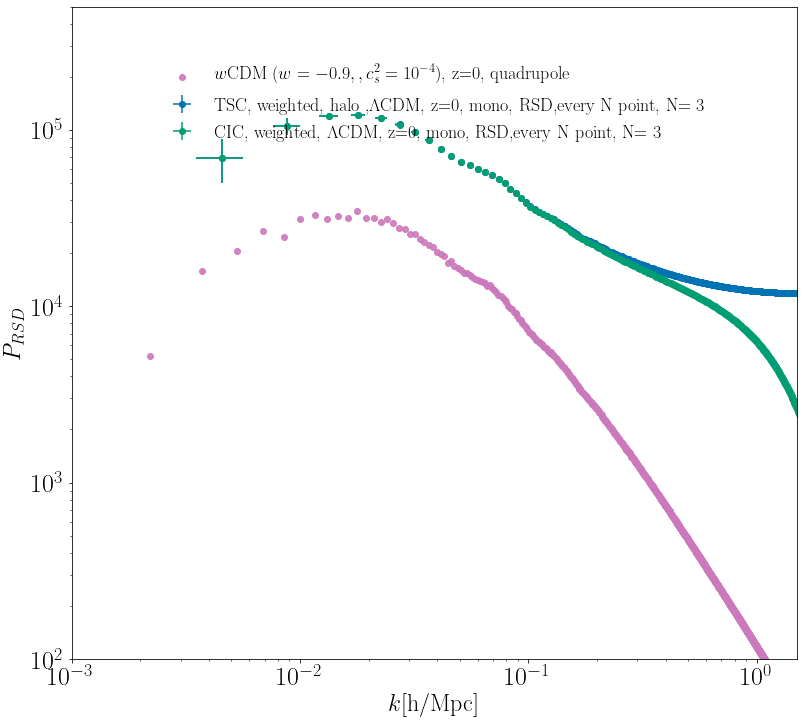

In [161]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
RSD ='RSD'

l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =3
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="TSC, weighted, "+kind+" ,"+decrip[num1]+redshift+", mono, "+RSD + ",every N point, N= "+str(number_binning))

        # CIC
        kind = "cross_TSC"
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halo num =1
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halo num =3
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halo num =3
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label="CIC, "+decrip[num1]+redshift+", monopole")
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l+2], ecolor=Colors[l+2], fmt='o', capthick=2,label="CIC, weighted, "+decrip[num1]+redshift+", mono, "+RSD + ",every N point, N= "+str(number_binning))

        l=l+1
        
kind = "cdm"
l=3
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =3
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", quadrupole, "+RSD + ",every N point, N= "+str(number_binning))

#         l=l+1
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e2,5.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.5, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


## quadrupole

method: every_N_point
method: every_N_point


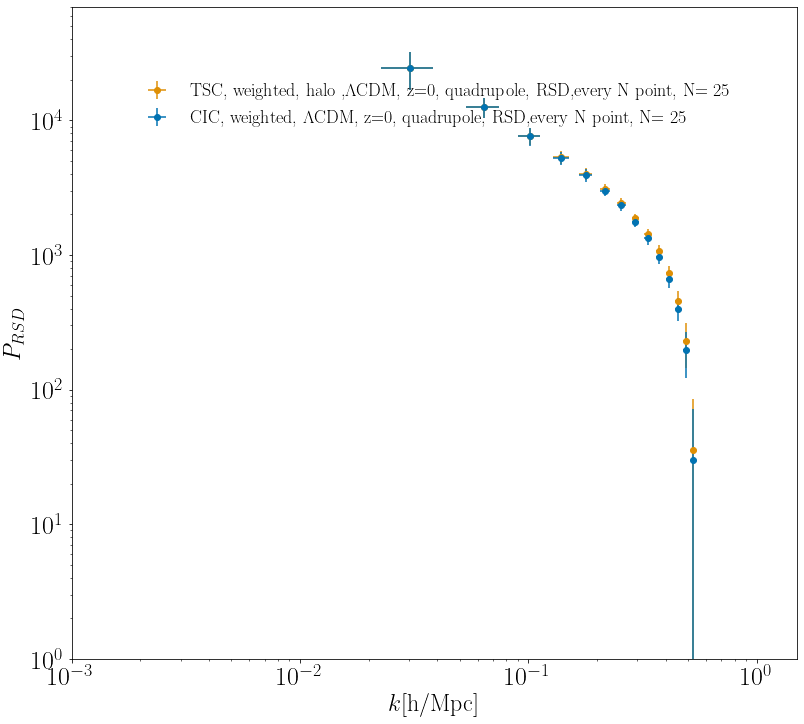

In [148]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
RSD ='RSD'

l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =25
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l+1], ecolor=Colors[l+1], fmt='o', capthick=2,label="TSC, weighted, "+kind+" ,"+decrip[num1]+redshift+", quadrupole, "+RSD + ",every N point, N= "+str(number_binning))

        # CIC
        kind = "cross_TSC"
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halo num =1
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halo num =3
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halo num =3
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label="CIC, "+decrip[num1]+redshift+", monopole")
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="CIC, weighted, "+decrip[num1]+redshift+", quadrupole, "+RSD + ",every N point, N= "+str(number_binning))

        l=l+1
        
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e0,7.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.5, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


## Hexadecapole

method: every_N_point
method: every_N_point


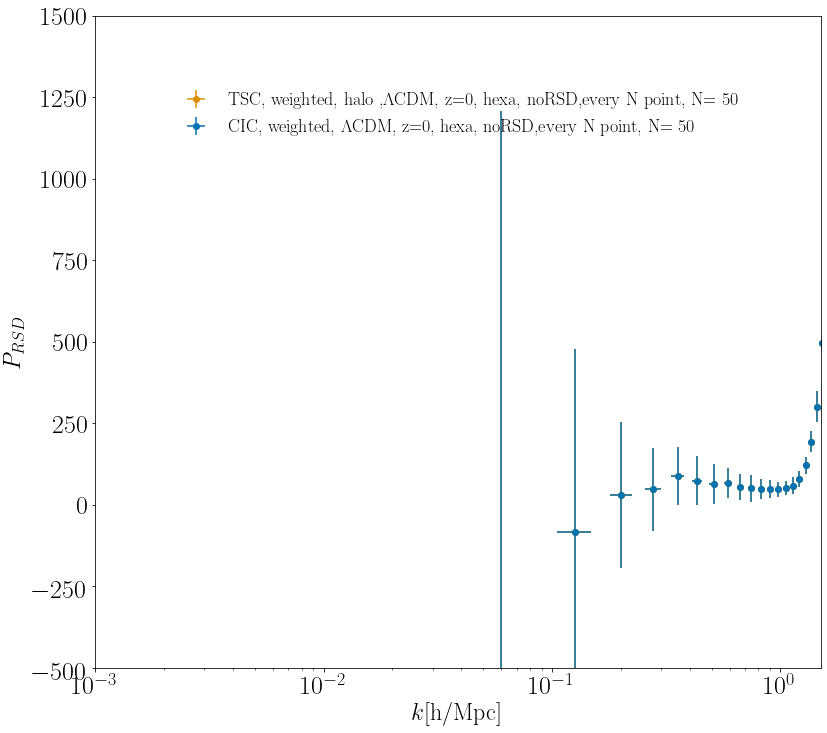

In [158]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
RSD ='noRSD'

l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", monopole")
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        number_binning  =50
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l+1], ecolor=Colors[l+1], fmt='o', capthick=2,label="TSC, weighted, "+kind+" ,"+decrip[num1]+redshift+", hexa, "+RSD + ",every N point, N= "+str(number_binning))

        # CIC
        kind = "cross_TSC"
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:] # monopole of halo num =1
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:] # quadrupole of halo num =3
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,5],:] # hexadecapole of halo num =3
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label="CIC, "+decrip[num1]+redshift+", monopole")
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="CIC, weighted, "+decrip[num1]+redshift+", hexa, "+RSD + ",every N point, N= "+str(number_binning))

        l=l+1
        
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('log')
axs.set_ylim(-500,1500)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.5, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)


# Noise reduction (Jack knife) and weighting based on mu

## The effect of shot nois (Jackknife) on monopole power

### no RSD

Text(0.5, 0, '$k$[h/Mpc]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


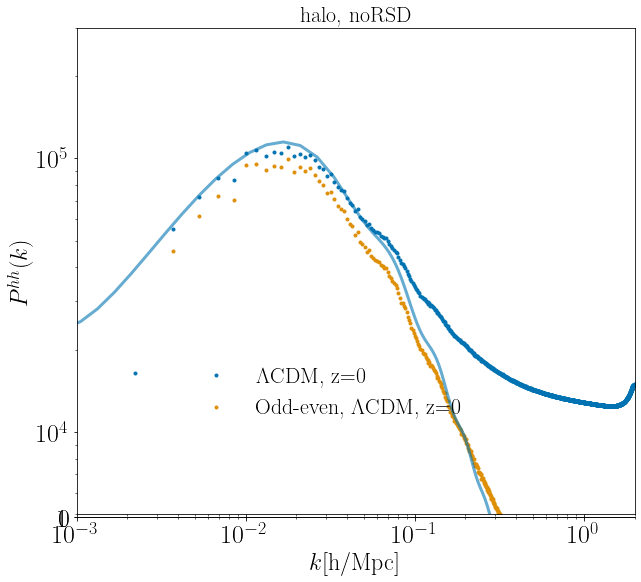

In [26]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(10,9),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,0]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','kev_em4','gev_em7','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        [k_w,pk]=data[kind][RSD][file[i]]['pow_jackknife'][redshift][[0,7],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l+1], lw=3,label="Odd-even, "+decrip[i]+redshift)

        bias_h = bias_halo_lin[file[i]][redshift]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * bias_h**2  ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P^{hh}(k)$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_title(kind+", "+RSD, fontsize=22)

# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(5.e3,3.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.45, 0.25], loc='center',frameon=False)
# Relative difference:

# l=0
# for num1 in [0,1,2,3,4]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][z[j]][[0,1],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][z[j]][[0,1],:]
#                 axs[1].plot(k1,(pk1)/pk2,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#                 l=l+1;
                
# l=0
# for num1 in [0,1,2,3]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):

#                 ### CLASS transfer
#                 redshift ="z="+str(j);
#                 # Transfer function:
#                 # LCDM
#                 k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
#                 d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
#                 d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
#                 # densities from the bg file
#                 rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
#                 rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
#                 d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
#                 interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)
#                 bias_h_lcdm = bias_halo_lin[file[num2]]['z='+str(redshifts[j])]

#                 #kessence
#                 k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
#                 d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
#                 d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
#                 rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
#                 rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
#                 d_m = (d_cdm * rho_cdm(np.double(j)) 
#                        + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
#                 interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)
#                 bias_h =bias_halo_lin[file[num1]]['z='+str(redshifts[j])]

#                 d_m = interp_delta (k_w)
#                 d_m_lcdm = interp_delta_lcdm (k_w)
                

#                 axs[1].plot(k_w, ((d_m*bias_h)/(d_m_lcdm*bias_h_lcdm))**2,"-.",color =Colors[l], lw=2)
#                 l=l+1

# axs[1].set_ylabel(r'$P^{hh}_X/P^{hh}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
# axs[1].set_xscale('log')
# # plt.yscale('symlog')
# axs[1].set_ylim(0.97,1.07)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
# axs[1].legend(fontsize=22,bbox_to_anchor=[0.6, 0.85], loc='center',frameon=False)
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('noRSD_halo_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


### Constant subtraction to see if the difference at quasi-linear regime is due to shot noise

Text(0.5, 0, '$k$[h/Mpc]')

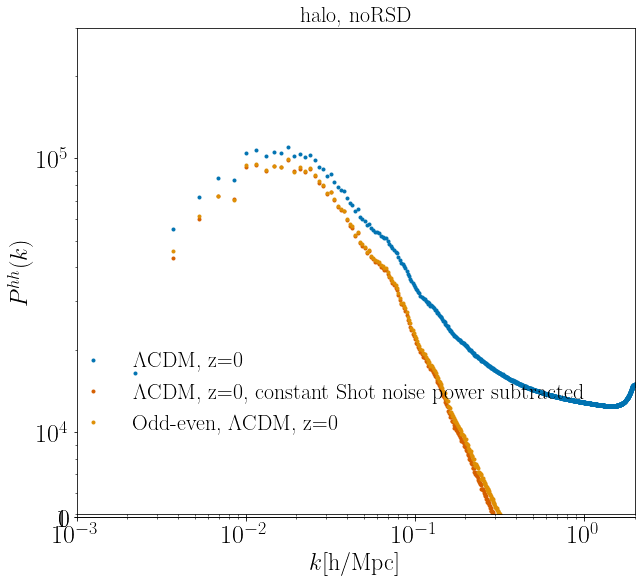

In [178]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(10,9),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,0]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','kev_em4','gev_em7','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)

#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
#         axs[0].loglog(k_w,pk-0.8*1.e4,".",color =Colors[l+4], lw=3,label=decrip[i]+redshift+", constant subtracted")

        
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk-1.1*1.e4,".",color =Colors[l+3], lw=3,label=decrip[i]+redshift+", constant Shot noise power subtracted")
       
        [k_w,pk]=data[kind][RSD][file[i]]['pow_jackknife'][redshift][[0,7],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l+1], lw=3,label="Odd-even, "+decrip[i]+redshift)

#         bias_h = bias_halo_lin[file[i]][redshift]
#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion * bias_h**2  ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P^{hh}(k)$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_title(kind+", "+RSD, fontsize=22)

# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(5.e3,3.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.45, 0.25], loc='center',frameon=False)

axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)



### RSD

Text(0.5, 0, '$k$[h/Mpc]')

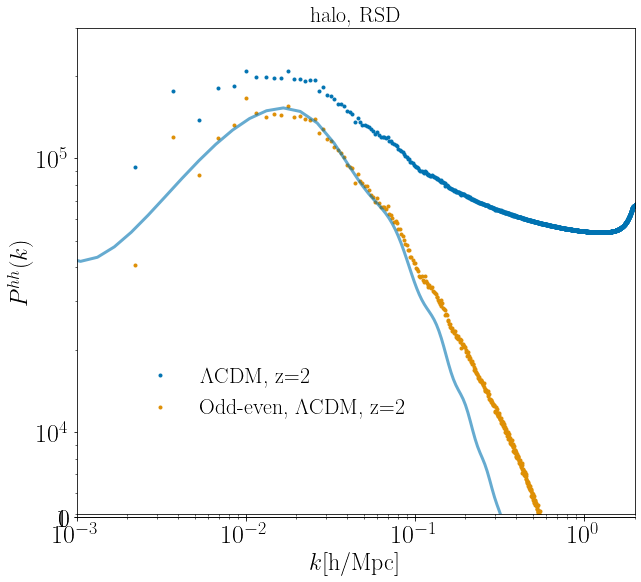

In [190]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(10,9),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,0]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','kev_em4','gev_em7','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0]: # file
    for j in [2]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        [k_w,pk]=data[kind][RSD][file[i]]['pow_jackknife'][redshift][[0,7],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l+1], lw=3,label="Odd-even, "+decrip[i]+redshift)

        bias_h = bias_halo_lin[file[i]][redshift]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * bias_h**2  ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P^{hh}(k)$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_title(kind+", "+RSD, fontsize=22)

# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(5.e3,3.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.35, 0.25], loc='center',frameon=False)

axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
# axs[1].set_xscale('log')
# # plt.yscale('symlog')
# axs[1].set_ylim(0.97,1.07)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
# axs[1].legend(fontsize=22,bbox_to_anchor=[0.6, 0.85], loc='center',frameon=False)
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('noRSD_halo_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


## The effect of Odd-even on quadrupole and hexa

### Moments - noise

#### RSD

Text(0.5, 1.0, 'halo, RSD')

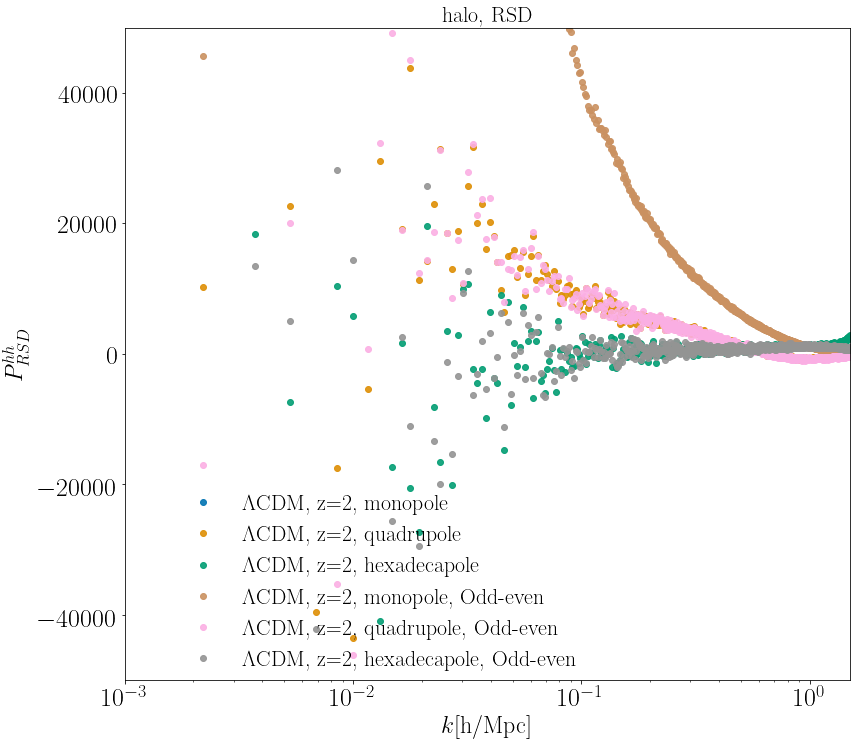

In [61]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [2]: # Redshifts
        redshift ="z="+str(j);
        [k0,pk0]=data[kind]['RSD'][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind]['RSD'][file[num1]]['pow'][redshift][[0,3],:]
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole")
        
        l=l+5
        [k0,pk0]=data[kind]['RSD'][file[num1]]['pow_jackknife'][redshift][[0,7],:]
        [k2,pk2]=data[kind]['RSD'][file[num1]]['pow_jackknife'][redshift][[0,8],:]
        [k4,pk4]=data[kind]['RSD'][file[num1]]['pow_jackknife'][redshift][[0,9],:]
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole, Odd-even")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole, Odd-even")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, Odd-even")
        l=l+1
#         c1 =  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
#         # P^2 = (4 b f)/3 + (4 f^2)/7
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-5.e4,5.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.35, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)
axs.set_title(kind+", "+RSD, fontsize=22)

# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


### no RSD

Text(0.5, 1.0, 'halo, noRSD')

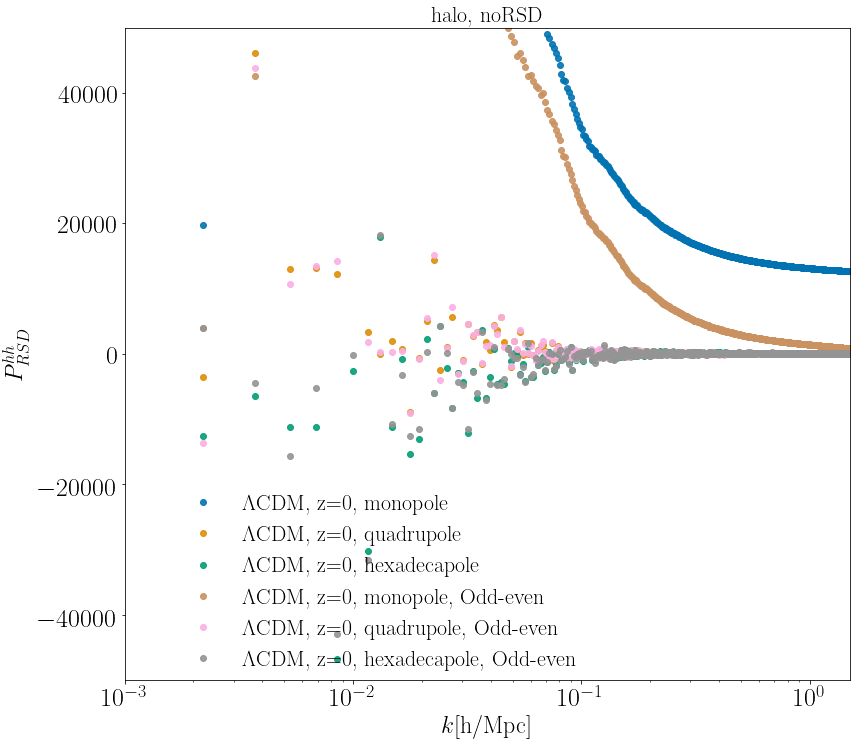

In [64]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole")
        
        l=l+5
        [k0,pk0]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,7],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,8],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,9],:]
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole, Odd-even")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole, Odd-even")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, Odd-even")
        l=l+1
#         c1 =  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
#         # P^2 = (4 b f)/3 + (4 f^2)/7
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-5.e4,5.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.35, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)
axs.set_title(kind+", "+RSD, fontsize=22)

# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


### hexadecapole RSD vs no RSD

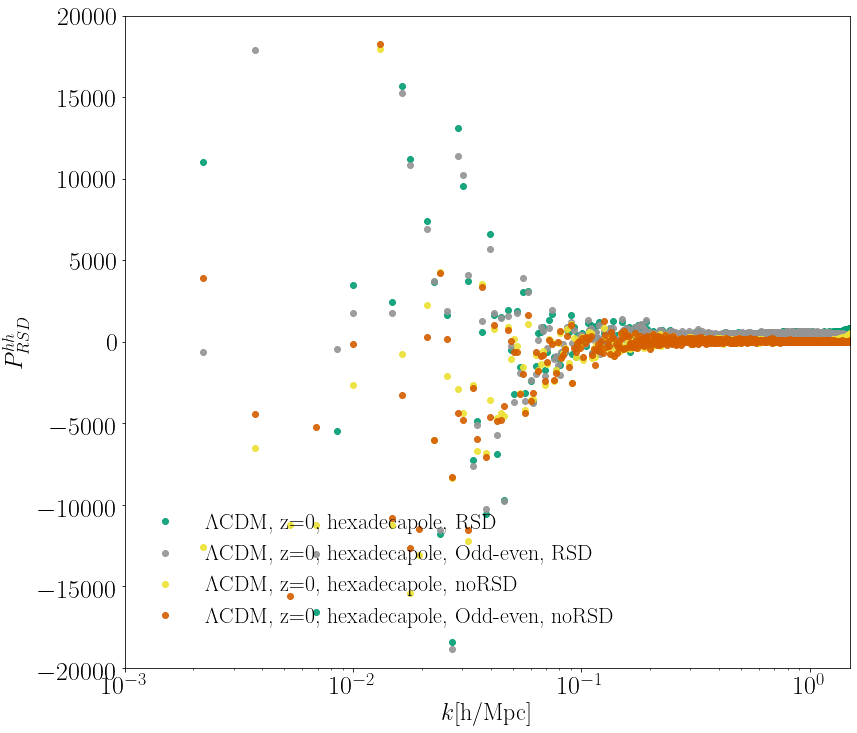

In [74]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        l=l+5
        [k0,pk0]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,7],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,8],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,9],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole, Odd-even")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole, Odd-even")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, Odd-even, "+RSD)
        l=l+1
        
        RSD ='noRSD'
        redshift ="z="+str(j);
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        l=l+5
        [k0,pk0]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,7],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,8],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow_jackknife'][redshift][[0,9],:]
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole, Odd-even")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole, Odd-even")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, Odd-even, "+RSD)
        l=l+1
#         c1 =  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
#         # P^2 = (4 b f)/3 + (4 f^2)/7
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-2.e4,2.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.35, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)
# axs.set_title(kind+", "+RSD, fontsize=22)

# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


## Weighted averaging and var

#### The number of modes:

Text(0.5, 0, 'k')

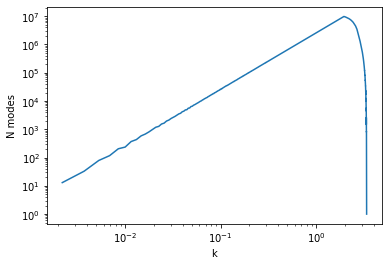

In [11]:
plt.loglog(data['halo']['RSD'][files_list[j]]['pow_jackknife']['z='+str(redshifts[i])][0,:],data['halo']['RSD'][files_list[j]]['pow_jackknife']['z='+str(redshifts[i])][10,:])
plt.ylabel("N modes")
plt.xlabel("k")


### Monopole

method: log
method: lin


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


method: every_N_point


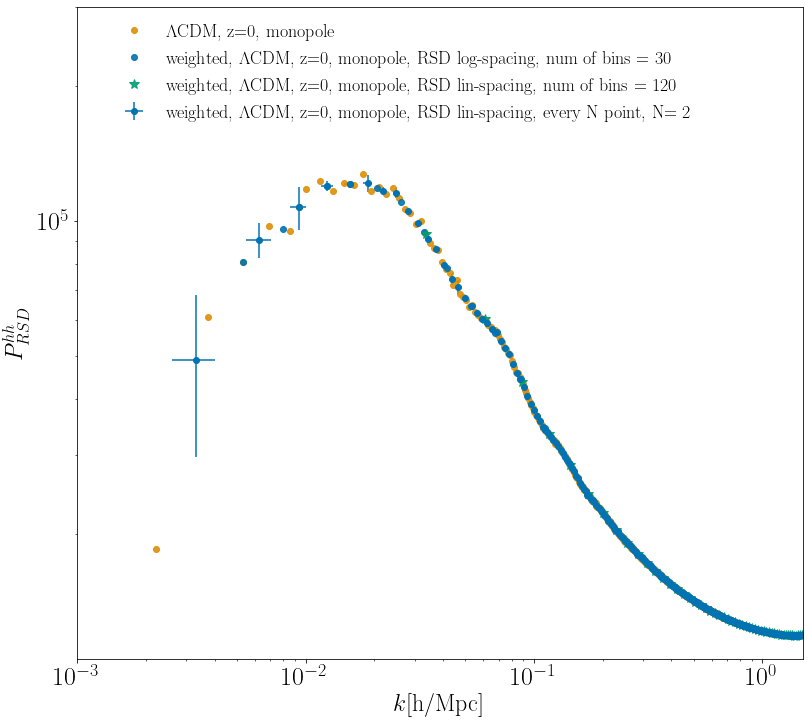

In [57]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
        axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 30;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 1;
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="weighted, "+decrip[num1]+redshift+", monopole, "+RSD + " log-spacing, num of bins = "+str(number_binning))
        
        number_binning = 120;
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"lin")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",alpha=0.9,color =Colors[l+2], markersize=10,label="weighted, "+decrip[num1]+redshift+", monopole, "+RSD + " lin-spacing, num of bins = "+str(number_binning))

        number_binning  =2
        weighted_arr = wighted_power(k0, pk0, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+decrip[num1]+redshift+", monopole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))

        
        l=l+1
    
axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(-2.e4,3.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.45, 0.9], loc='center',frameon=False)
X=np.arange(0.001,20,1)


### Quadrupole

method: log
method: lin
method: every_N_point


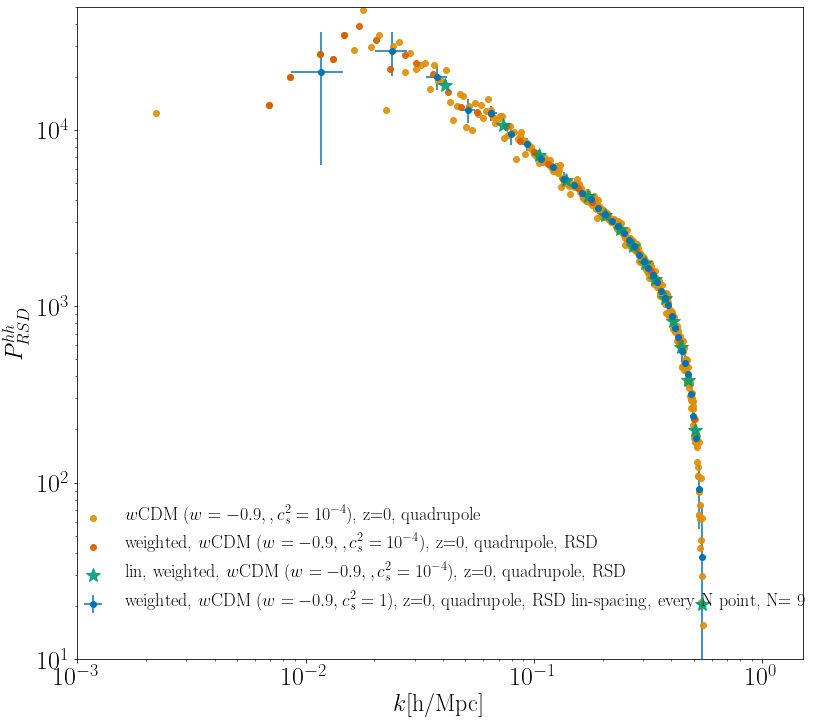

In [64]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l+3], lw=3,label="weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)
        
        number_binning = 100;
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)

        number_binning  =9
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+decrip[num1]+redshift+", quadrupole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))

        l=l+1
    
axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e1,5.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.5, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


#### quadrupole cdm

method: every_N_point
method: every_N_point


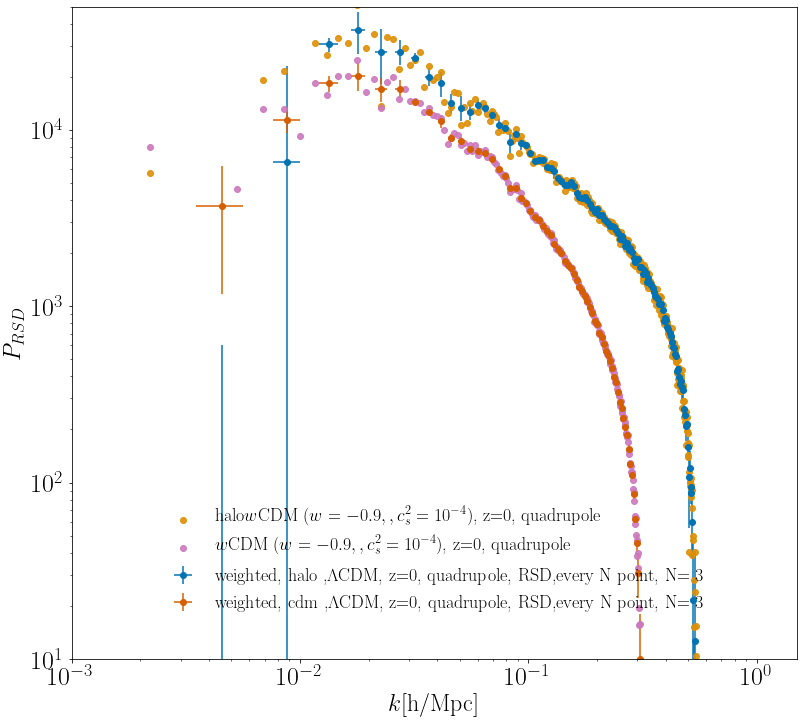

In [91]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)




# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=kind+decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l+3], lw=3,label="weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)
        
#         number_binning = 100;
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)

        number_binning  =3
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", quadrupole, "+RSD + ",every N point, N= "+str(number_binning))

        l=l+1
        
kind = "cdm"
l=3
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 50;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 0;
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l+3], lw=3,label="weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)
        
#         number_binning = 100;
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)

        number_binning  =3
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", quadrupole, "+RSD + ",every N point, N= "+str(number_binning))

        l=l+1
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
plt.yscale('log')
axs.set_ylim(1.e1,5.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=18,bbox_to_anchor=[0.5, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


##### no RSD to see that it vanishes

method: every_N_point


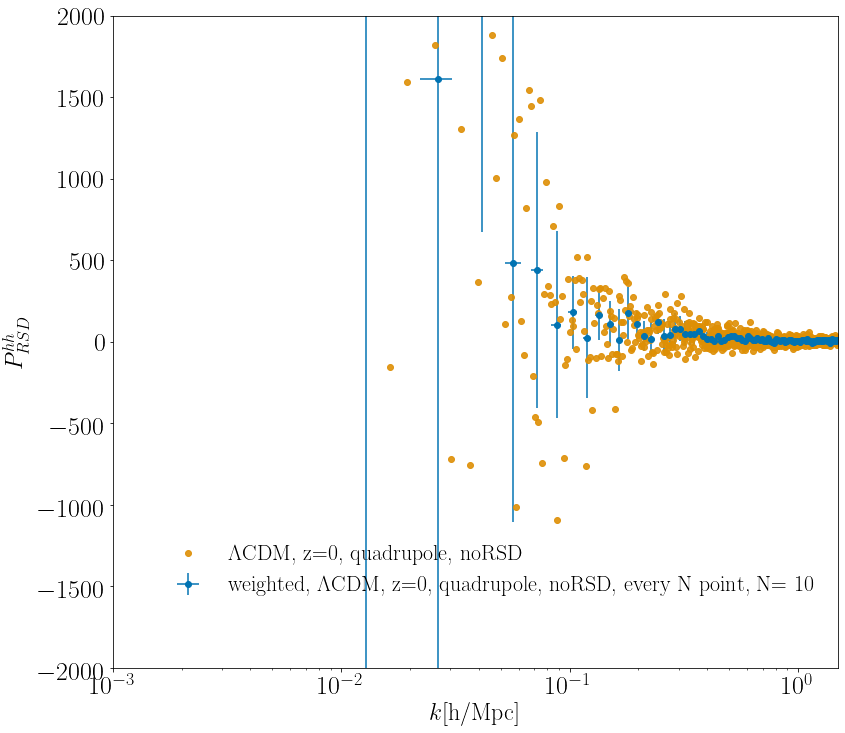

In [75]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='noRSD'
        [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", monopole")
        axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", quadrupole, "+RSD)
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 10;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l+3], lw=3,label="log weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)

#         number_binning = 200
#         weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=10,alpha=0.9,color =Colors[l+2], lw=3,label="lin weighted, "+decrip[i]+redshift+", quadrupole, "+RSD)

        number_binning  =10
        weighted_arr = wighted_power(k0, pk2, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+decrip[num1]+redshift+", quadrupole, "+RSD + ", every N point, N= "+str(number_binning))

        l=l+1
    
axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('log')
axs.set_ylim(-2.e3,2.e3)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.52, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


###  hexadecapole

method: log
method: every_N_point


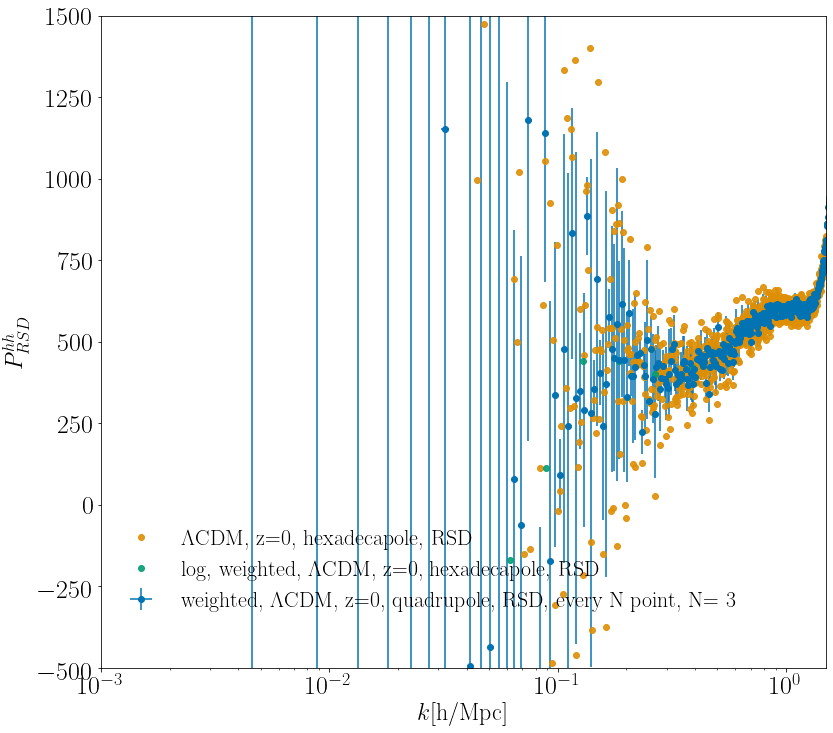

In [92]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
# RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 20;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 1;
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l+2], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         number_binning = 80
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        number_binning  =3
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+decrip[num1]+redshift+", quadrupole, "+RSD + ", every N point, N= "+str(number_binning))


        l=l+1
    
axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-500,1500)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.45, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


###  hexadecapole CDM + halo

method: every_N_point
method: every_N_point
method: every_N_point
method: every_N_point


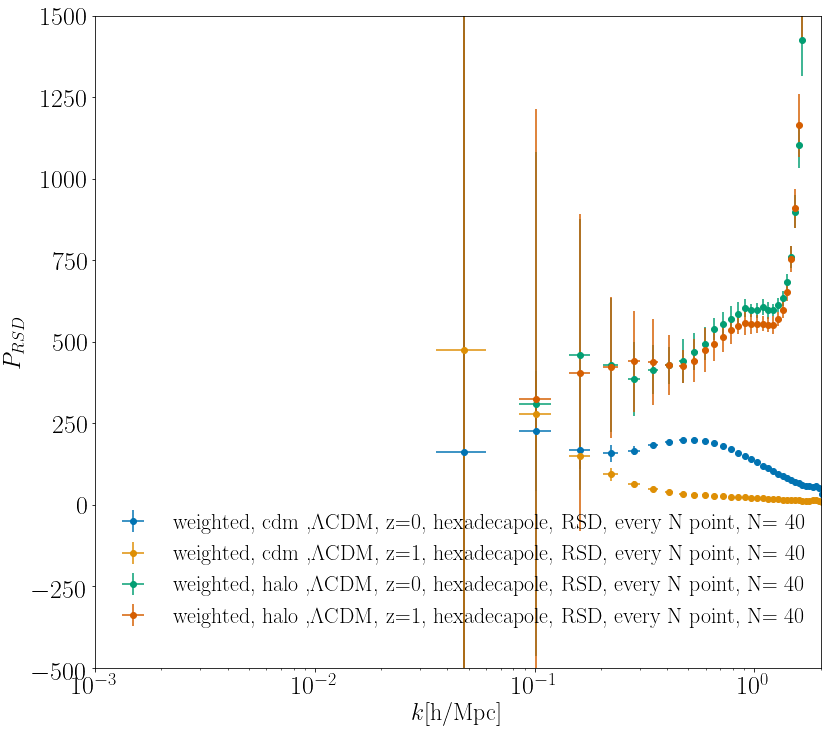

In [102]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 20;
        kmin = k0.min();
        kmax = k0.max();
#         nyqvist_skip = 1;
#         cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         number_binning = 150
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        number_binning  =40
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))

        l=l+1
        
kind = "halo"
l=2
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='RSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 20;
#         kmin = k0.min();
#         kmax = k0.max();
#         nyqvist_skip = 1;
#         cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        number_binning = 40
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",markersize=10,alpha=0.9,color =Colors[l+1], lw=3,label="hh- lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)

        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))


        l=l+1
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-500,1500)
axs.set_xlim(1.e-3,2)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.5, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


##### no RSD

method: log
method: lin


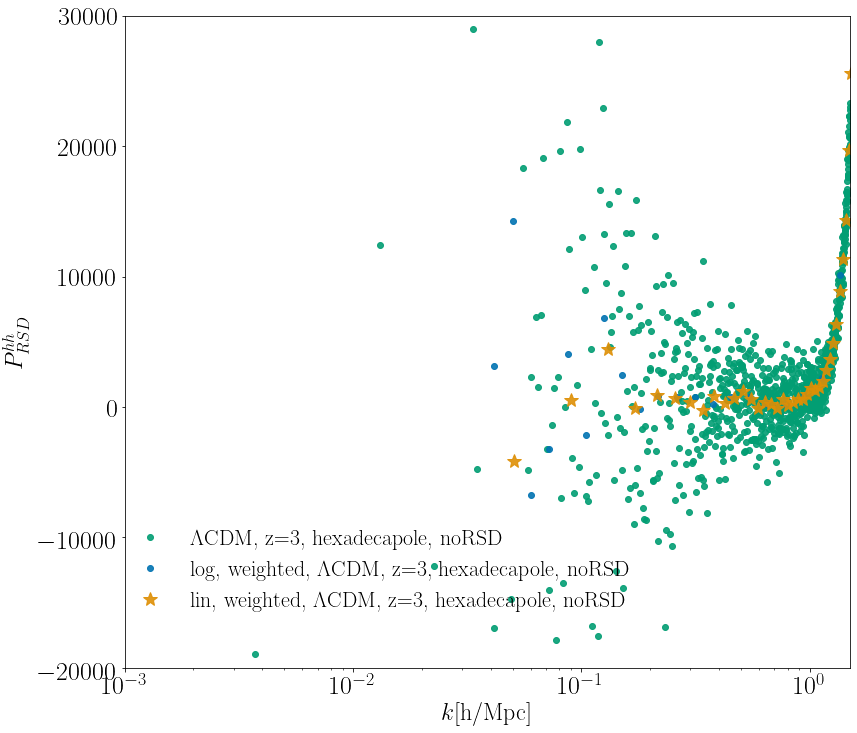

In [237]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [3]: # Redshifts
        redshift ="z="+str(j);
        RSD ='noRSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
        axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
        number_binning = 40;
        kmin = k0.min();
        kmax = k0.max();
        nyqvist_skip = 1;
        cosmicvar_skip = 3;
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[i]+redshift+", hexadecapole, "+RSD)
        number_binning = 80;
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
        axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+1], lw=3,label="lin, weighted, "+decrip[i]+redshift+", hexadecapole, "+RSD)

        l=l+1
    
axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-2.e4,3.e4)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.35, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


#### Hexadecapole no RSD, cdm and halo

method: every_N_point
method: every_N_point


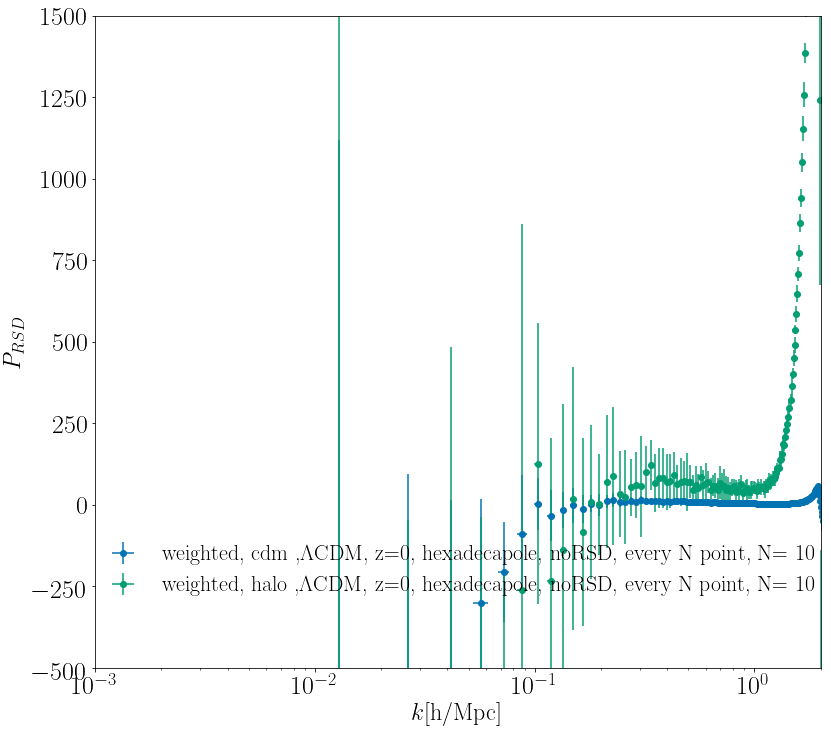

In [105]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='noRSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 20;
        kmin = k0.min();
        kmax = k0.max();
#         nyqvist_skip = 1;
#         cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         number_binning = 150
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        number_binning  =10
        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))

        l=l+1
        
kind = "halo"
l=2
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='noRSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 20;
#         kmin = k0.min();
#         kmax = k0.max();
#         nyqvist_skip = 1;
#         cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        number_binning = 10
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",markersize=10,alpha=0.9,color =Colors[l+1], lw=3,label="hh- lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)

        weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))


        l=l+1
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-500,1500)
axs.set_xlim(1.e-3,2)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.5, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


method: every_N_point
method: every_N_point


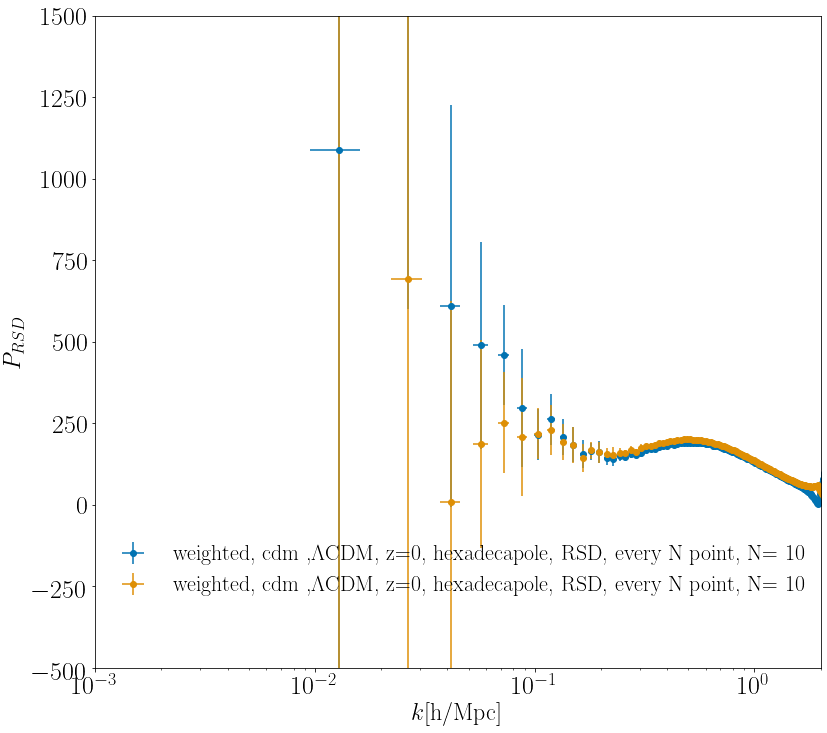

In [157]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        RSD ='noRSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4_no_RSD]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
        redshift ="z="+str(j);
        RSD ='RSD'
#         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
        [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
        [k4,pk4_RSD]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
#         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
#         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
#         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
        # Averaging weighted based on the # of modes
        count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
#         number_binning = 20;
        kmin = k0.min();
        kmax = k0.max();
#         nyqvist_skip = 1;
#         cosmicvar_skip = 1;
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         number_binning = 150
#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
#         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"*",markersize=15,alpha=0.9,color =Colors[l+2], lw=3,label="lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        number_binning  =10
        weighted_arr_RSD = wighted_power(k0, pk4_RSD, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
        weighted_arr_noRSD = wighted_power(k0, pk4_no_RSD, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")

        #         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
        errorbar(weighted_arr_RSD[:,0], (weighted_arr_RSD[:,1]-weighted_arr_noRSD[:,1]), xerr=np.sqrt(weighted_arr_noRSD[:,2]),yerr=np.sqrt(weighted_arr_noRSD[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))

        errorbar(weighted_arr_RSD[:,0], (weighted_arr_RSD[:,1]), xerr=np.sqrt(weighted_arr_noRSD[:,2]),yerr=np.sqrt(weighted_arr_noRSD[:,3]),color =Colors[l+1], ecolor=Colors[l+1], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))

        l=l+1
        
# kind = "halo"
# l=2
# for num1 in [0]: # file 1
#     for j in [0]: # Redshifts
#         redshift ="z="+str(j);
#         RSD ='noRSD'
# #         [k0,pk0]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
#         [k2,pk2]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
#         [k4,pk4]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
        
# #         axs.plot(k0, pk0,"o",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+redshift+", monopole")
# #         axs.plot(k0, pk2,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+redshift+", quadrupole")
# #         axs.plot(k0, pk4,"o",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         # Averaging weighted based on the # of modes
#         count_arr = data[kind][RSD][file[num1]]['pow'][redshift][5,:]
# #         number_binning = 20;
# #         kmin = k0.min();
# #         kmax = k0.max();
# #         nyqvist_skip = 1;
# #         cosmicvar_skip = 1;
# #         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"log")
# #         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",alpha=0.9,color =Colors[l], lw=3,label="log, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)
        
#         number_binning = 10
# #         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, nyqvist_skip,cosmicvar_skip,"lin")
# #         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"o",markersize=10,alpha=0.9,color =Colors[l+1], lw=3,label="hh- lin, weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD)

#         weighted_arr = wighted_power(k0, pk4, count_arr ,number_binning, kmin, kmax, 0,0,"every_N_point")
# #         axs.plot(weighted_arr[:,0], weighted_arr[:,1],"s",alpha=0.9,color =Colors[l+4], markersize=4,label="weighted, "+decrip[num1]+redshift+", hexadecapole, "+RSD + " lin-spacing, every N point, N= "+str(number_binning))
#         errorbar(weighted_arr[:,0], weighted_arr[:,1], xerr=np.sqrt(weighted_arr[:,2]),yerr=np.sqrt(weighted_arr[:,3]),color =Colors[l], ecolor=Colors[l], fmt='o', capthick=2,label="weighted, "+kind+" ,"+decrip[num1]+redshift+", hexadecapole, "+RSD + ", every N point, N= "+str(number_binning))


#         l=l+1
    
axs.set_ylabel(r'$P_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('symlog')
axs.set_ylim(-500,1500)
axs.set_xlim(1.e-3,2)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.5, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)


In [151]:
np.shape(weighted_arr_RSD[:,1])
np.shape(weighted_arr_noRSD)

(216, 5)

# Halo Powerspectra comparison,  no RSD 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


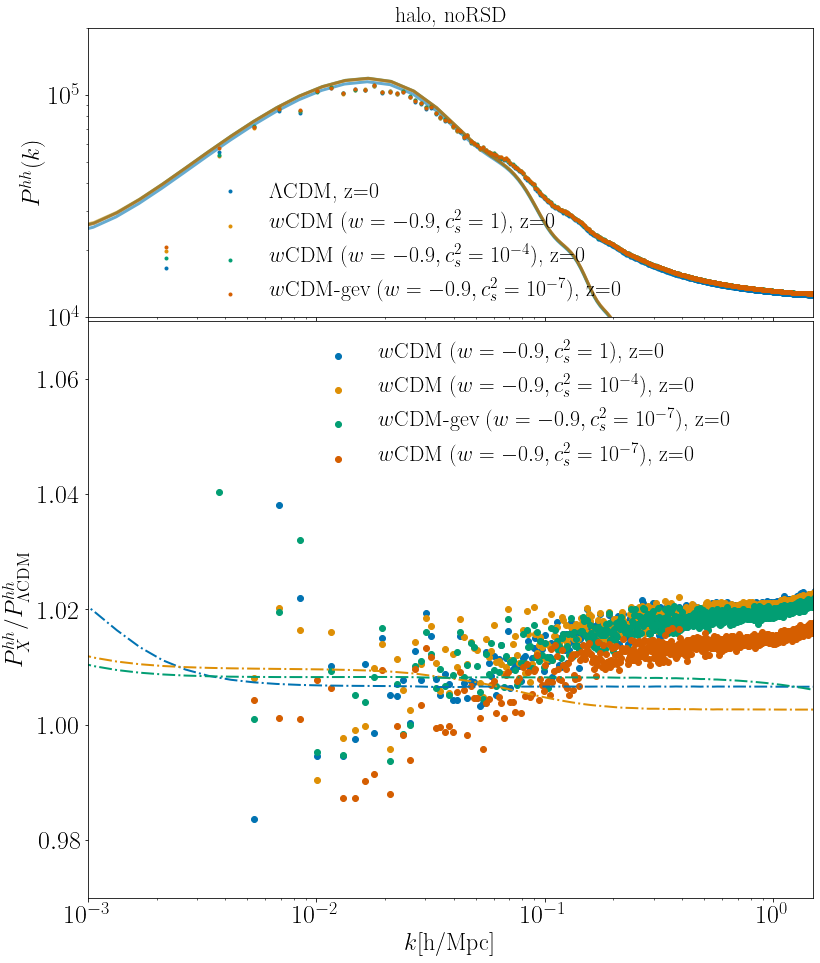

In [9]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','kev_em4','gev_em7','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j])
        bias_h = bias_halo_lin[file[i]][redshift]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * bias_h**2  ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P^{hh}(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_title(kind+", "+RSD, fontsize=22)

# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(1.e4,2.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.45, 0.25], loc='center',frameon=False)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][z[j]][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][z[j]][[0,1],:]
                axs[1].plot(k1,(pk1)/pk2,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
                l=l+1;
                
l=0
for num1 in [0,1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)
                bias_h_lcdm = bias_halo_lin[file[num2]]['z='+str(redshifts[j])]

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)
                bias_h =bias_halo_lin[file[num1]]['z='+str(redshifts[j])]

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)
                

                axs[1].plot(k_w, ((d_m*bias_h)/(d_m_lcdm*bias_h_lcdm))**2,"-.",color =Colors[l], lw=2)
                l=l+1

axs[1].set_ylabel(r'$P^{hh}_X/P^{hh}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.97,1.07)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.6, 0.85], loc='center',frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('noRSD_halo_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# Halo Powerspectra comparison,  RSD

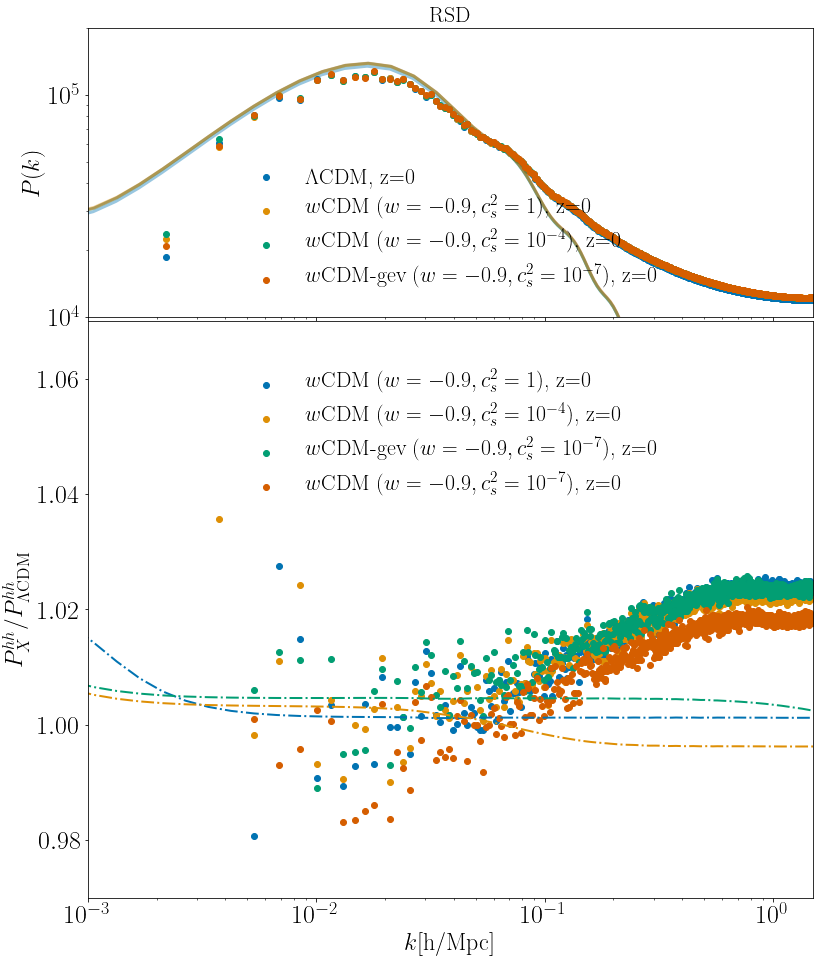

In [10]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        
        bias_h = bias_halo_lin[file[i]]['z='+str(redshifts[j])]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion  * np.double(rsd_coeff_halo[files_list_class[i]]['z='+str(z_f[j])]) ,"-",alpha=0.4,color =Colors[l], lw=3)

        l=l+1
# l=3
# RSD ='noRSD'
# for i in [0,3]: # file
#     for j in [0]: # Redshifts
#         redshift ="z="+str(j);
#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
#         axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j])
        
#         bias_h = bias_halo_lin[file[i]]['z='+str(redshifts[j])]
#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion  * bias_h**2,"-",alpha=0.4,color =Colors[l], lw=3)

#         l=l+1

axs[0].set_title(RSD, fontsize=22)

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(1.e4,2.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.3], loc='center',frameon=False)
# Relative difference:

RSD ='RSD'
l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][z[j]][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][z[j]][[0,1],:]
                axs[1].plot(k1,(pk1)/pk2,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
                l=l+1;

l=0
for num1 in [1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)
                RSD_lcdm =np.double(rsd_coeff_halo[files_list_class[num2]][redshift])
                RSD_wcdm =np.double(rsd_coeff_halo[files_list_class[num1]][redshift])

                axs[1].plot(k_w, (d_m**2*RSD_wcdm)/(d_m_lcdm**2*RSD_lcdm),"-.",color =Colors[l], lw=2)
                l=l+1

                
axs[1].set_ylabel(r'$P^{hh}_X/P^{hh}_{\Lambda \rm{CDM}}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.97,1.07)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center',frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_halos_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


In [205]:
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];

print(np.double(rsd_coeff_halo['lcdm']['z=0']))
print(np.double(rsd_coeff_halo['cs2_1']['z=0']))
print(np.double(rsd_coeff_halo['cs2_e4']['z=0']))

5.3785984358219
5.676736205537763
5.640393517971705


# Halo power RSD and no-RSD

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


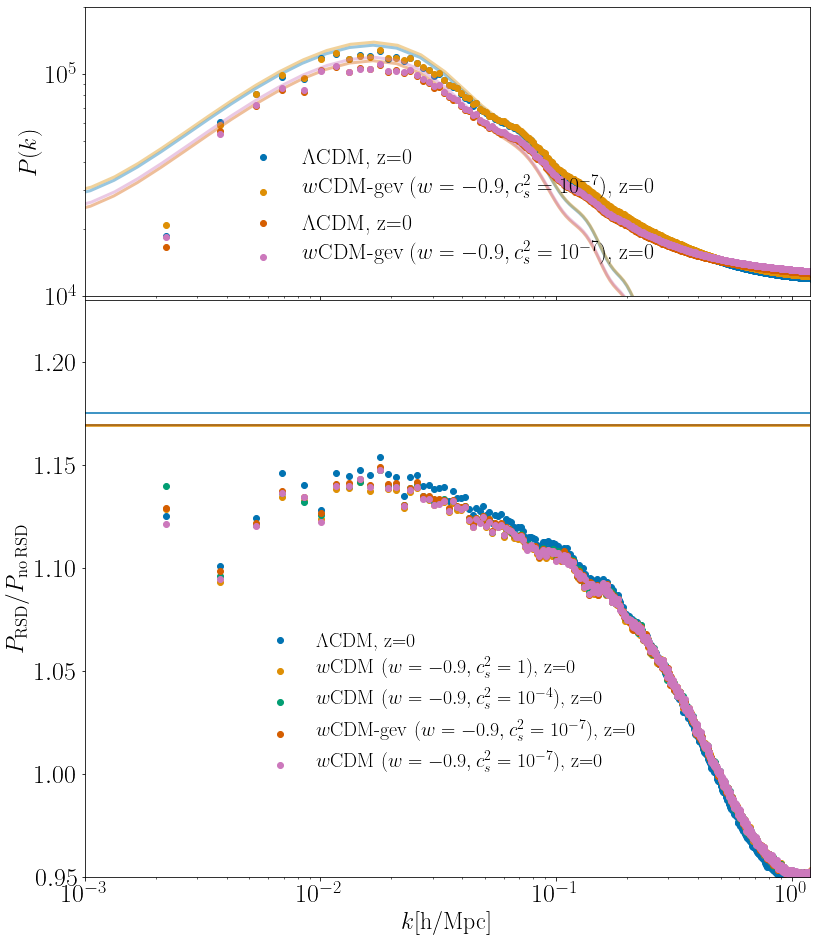

In [11]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        
        bias_h = bias_halo_lin[file[i]]['z='+str(redshifts[j])]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion  * np.double(rsd_coeff_halo[files_list_class[i]]['z='+str(z_f[j])]) ,"-",alpha=0.4,color =Colors[l], lw=3)

        l=l+1
l=3
RSD ='noRSD'
for i in [0,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].loglog(k_w,pk,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        
        bias_h = bias_halo_lin[file[i]]['z='+str(redshifts[j])]
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion  * bias_h**2,"-",alpha=0.4,color =Colors[l], lw=3)

        l=l+1
        
        
# axs[0].set_title(RSD, fontsize=22)

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(1.e4,2.e5)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.3], loc='center',frameon=False)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
l=0
for num1 in [0,1,2,3]: # file 1
    for j in [0]: # Redshifts
            bias_h = bias_halo_lin[file[num1]]['z='+str(redshifts[j])]
            axs[1].axhline(y=(np.double(rsd_coeff_halo[files_list_class[num1]]['z='+str(z_f[j])])/(bias_h)**2) , color=Colors[l], linestyle='-')
            l=l+1;


axs[1].set_ylabel(r'$P_{\rm RSD}/P_{\rm no \, RSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.95,1.23)
axs[1].set_xlim(1.e-3,1.2)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.5, 0.3], loc='center',frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_to_noRSD_halo.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# Halo power spectra moment

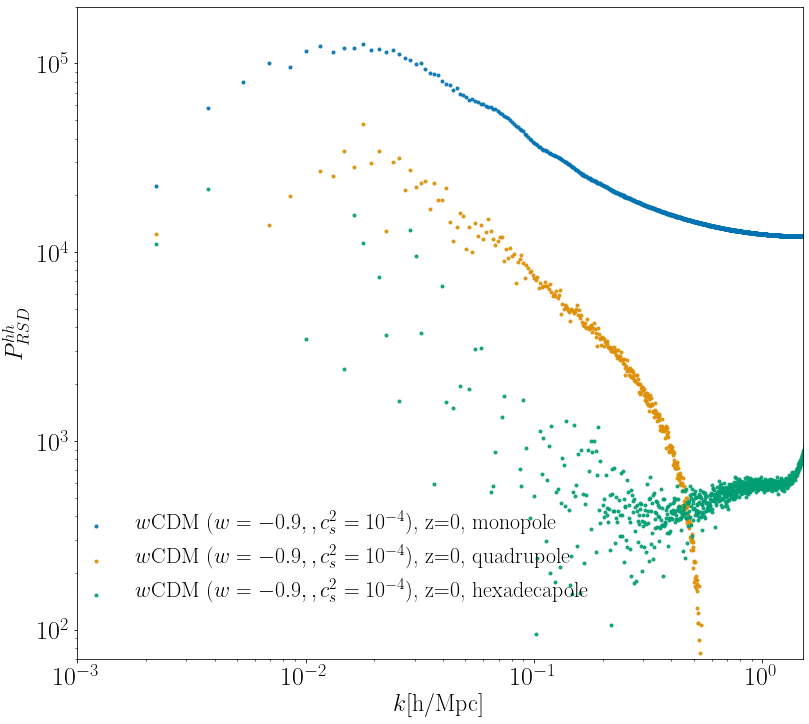

In [253]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0]: # Redshifts
        [k0,pk0]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
        [k2,pk2]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,2],:]
        [k4,pk4]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,3],:]
        axs.loglog(k0, pk0,".",alpha=0.9,color =Colors[l], lw=3,label=decrip[i]+z[j]+", monopole")
        axs.loglog(k0, pk2,".",alpha=0.9,color =Colors[l+1], lw=3,label=decrip[i]+z[j]+", quadrupole")
        axs.loglog(k0, pk4,".",alpha=0.9,color =Colors[l+2], lw=3,label=decrip[i]+z[j]+", hexadecapole")

        l=l+1
#         c1 =  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
#         # P^2 = (4 b f)/3 + (4 f^2)/7
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P^{hh}_{RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('log')
axs.set_ylim(7.e1,2.e5)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.35, 0.15], loc='center',frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


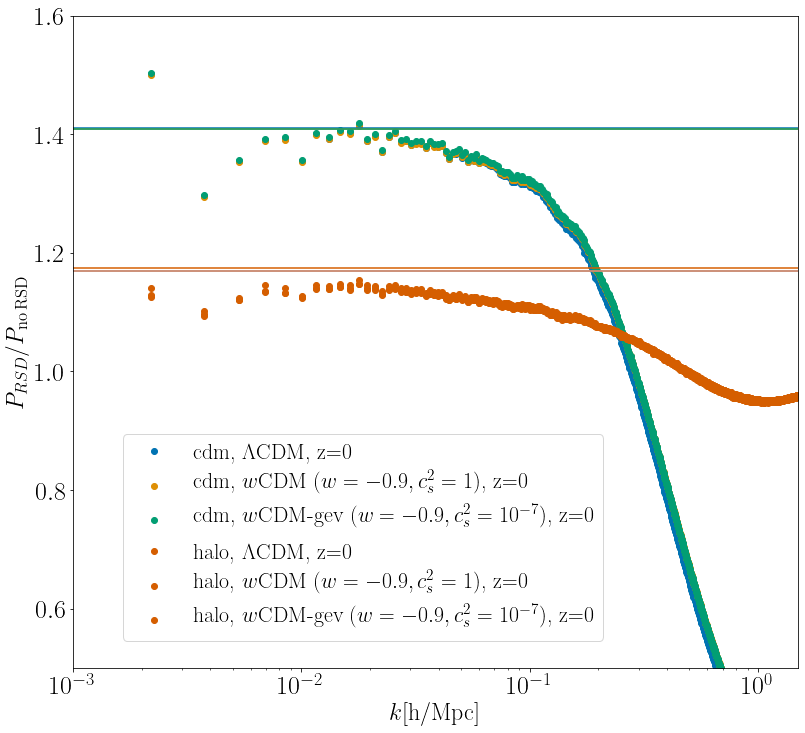

In [228]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0,1,2]: # file 1
    for j in [0]: # Redshifts
        [k0,pk0]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
        [k0,pk2]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,2],:]
        [k0,pk4]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,3],:]

        c1 = pk0/pk4  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
        c2 = pk2/pk4 # P^2 = (4 b f)/3 + (4 f^2)/7
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P_{RSD}/P_{\rm no \, RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('log')
axs.set_ylim(0.5,1.6)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.4, 0.2], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Linear Halo bias from the moments

In [ ]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12))
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0,1,2]: # file 1
    for j in [0]: # Redshifts
        [k0,pk0]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
        [k0,pk2]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,2],:]
        [k0,pk4]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,3],:]

#         c1 = pk0/pk4  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
#         c2 = pk2/pk4 # P^2 = (4 b f)/3 + (4 f^2)/7
        
#         c1 = np.mean(c1[8:30])
#         c1 = np.mean(c2[8:30])
#         y = symbols('f')
#         eq1 = Eq(35./(6.*f) 5./2.)
#         sol = solve(eq1)
        
        # P^4 = (8 f^2)/35

axs.set_ylabel(r'$P_{RSD}/P_{\rm no \, RSD}$',fontsize=24)
axs.set_xlabel('$k$[h/Mpc]',fontsize=24)
axs.set_xscale('log')
# plt.yscale('log')
axs.set_ylim(0.5,1.6)
axs.set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs.legend(fontsize=22,bbox_to_anchor=[0.4, 0.2], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


In [288]:
num1=0
[k0,pk0]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,1],:]
[k0,pk2]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,2],:]
[k0,pk4]=data[kind]['RSD'][file[num1]]['pow']['z='+str(z_f[j])][[0,3],:]

c1 = pk0/pk4  # P^0 = (b^2 + (2 b f)/3 + f^2/5)
c2 = pk2/pk4 # P^2 = (4 b f)/3 + (4 f^2)/7

c1 = np.mean(c1[5:30])
c2 = np.mean(c2[5:30])
# c2
print(c1,c2)

4.180579813979008 0.4249962671954345


In [282]:
bias_h = bias_halo_lin[file[0]]['z=0']
f = f_gr_data[files_list_class[0]]['z=0']
(bias_h,f)

(2.169218274529993, array(0.53073438))

# Halo vs cdm, RSD and noRSD redshift evolution

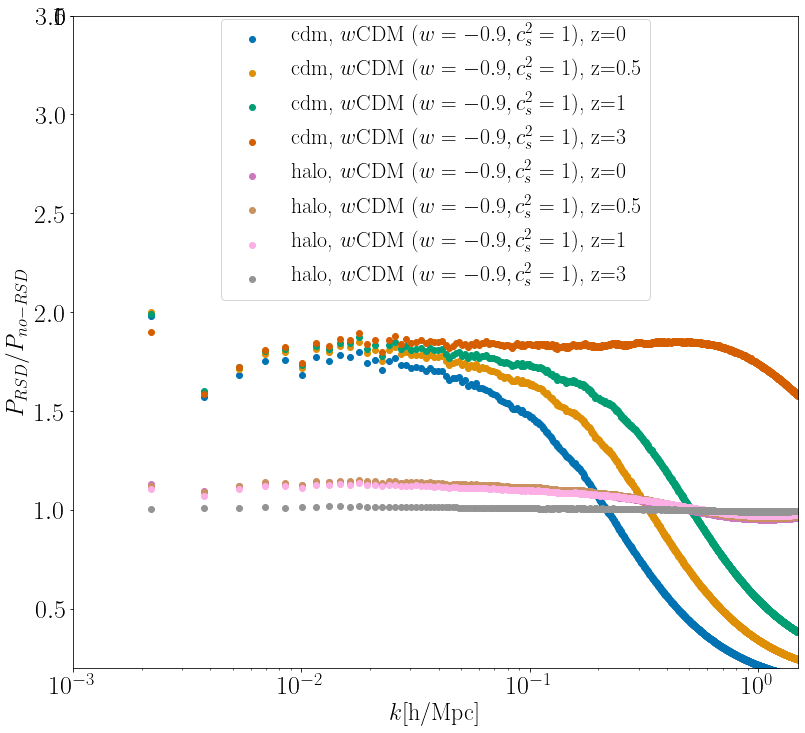

In [261]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


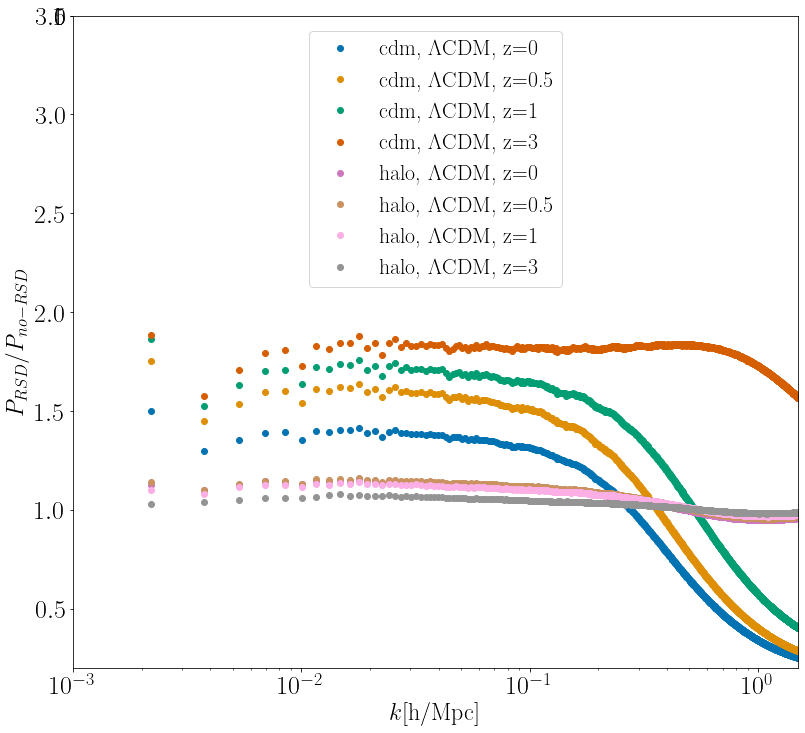

In [103]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [0]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo over cdm power spectrum

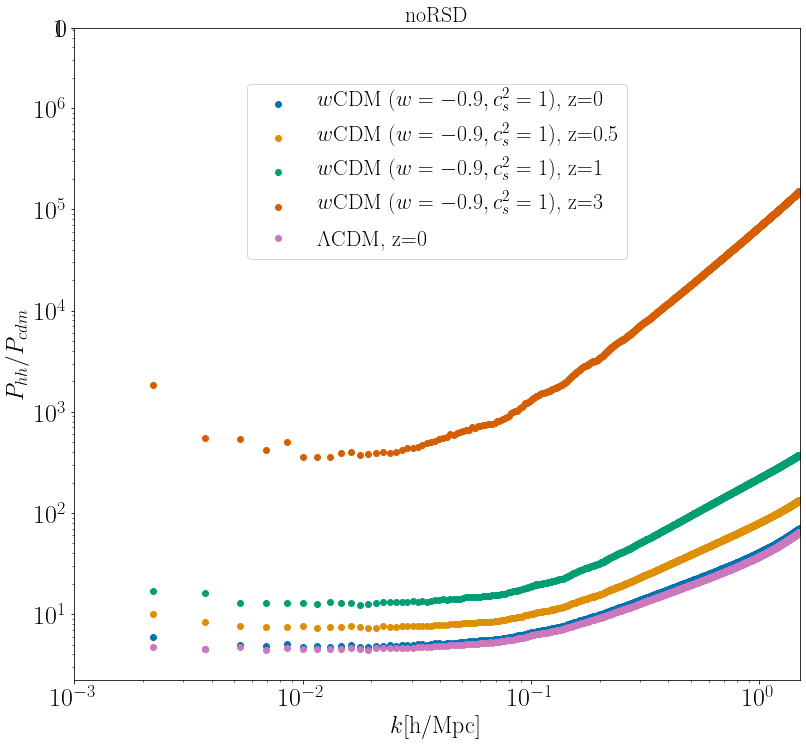

In [271]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind1 = "cdm"
kind2 = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
axs[1].set_title(RSD, fontsize=22)
axs[1].set_ylabel('$P_{hh}/P_{cdm}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
plt.yscale('log')
# axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


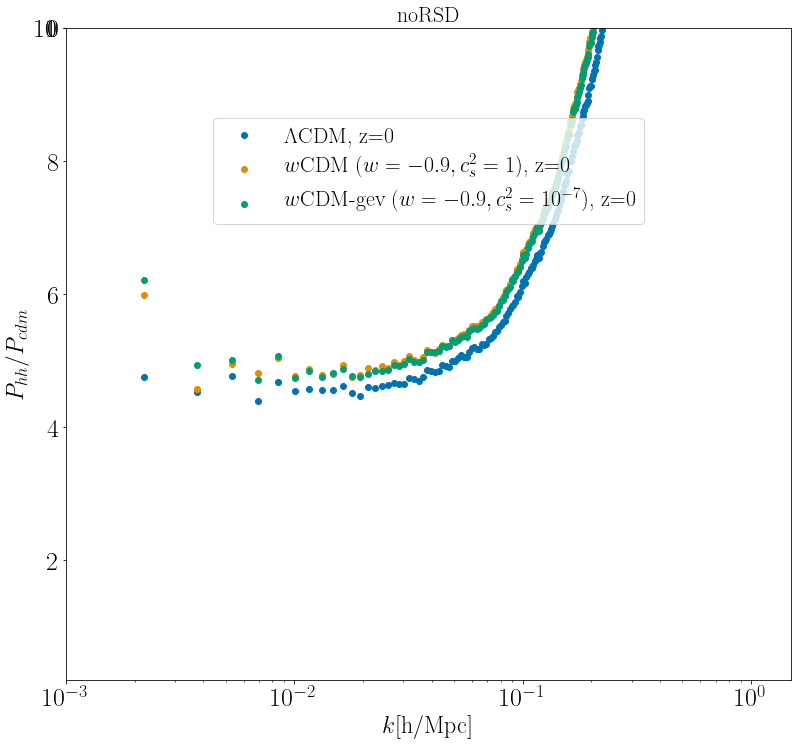

In [287]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind1 = "cdm"
kind2 = "halo"
l=0
for num1 in [0,1,2]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
# for num1 in [0,1]: # file 1
#     for j in [0]: # Redshifts
#             [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
#             [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
#             axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#             l=l+1;
axs[1].set_title(RSD, fontsize=22)
axs[1].set_ylabel('$P_{hh}/P_{cdm}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,10)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Correlation function cdm, no RSD

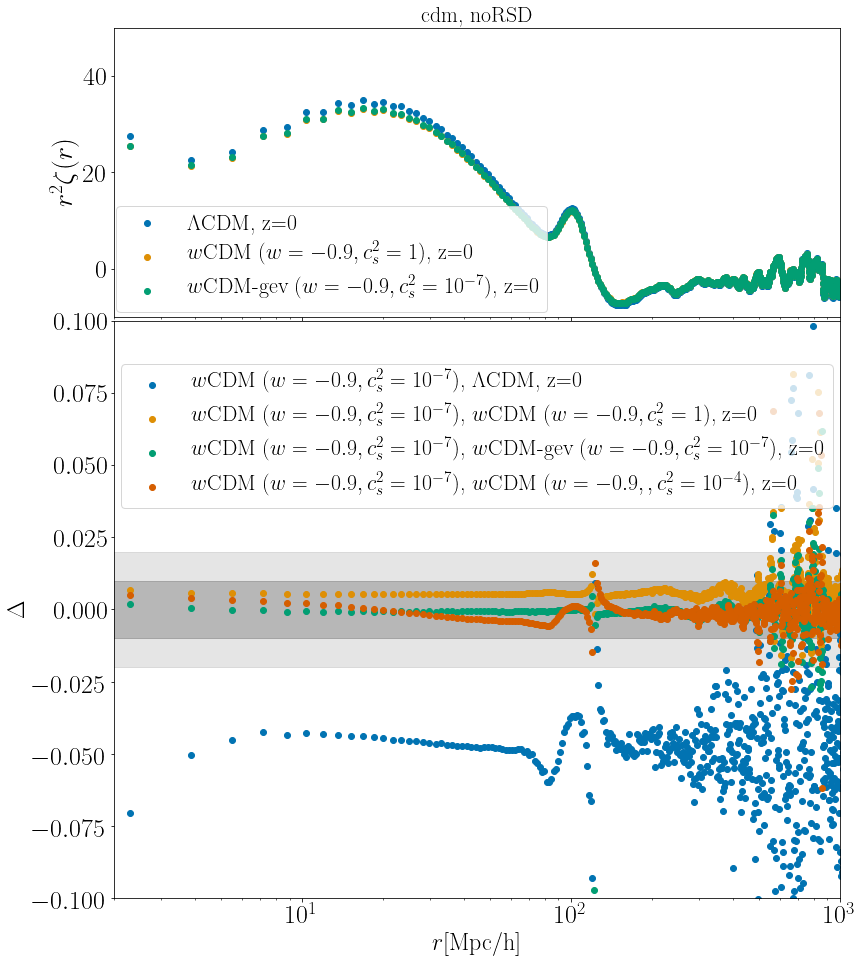

In [306]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='noRSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-10,50)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.3, 0.2], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(k1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Correlation function cdm, RSD

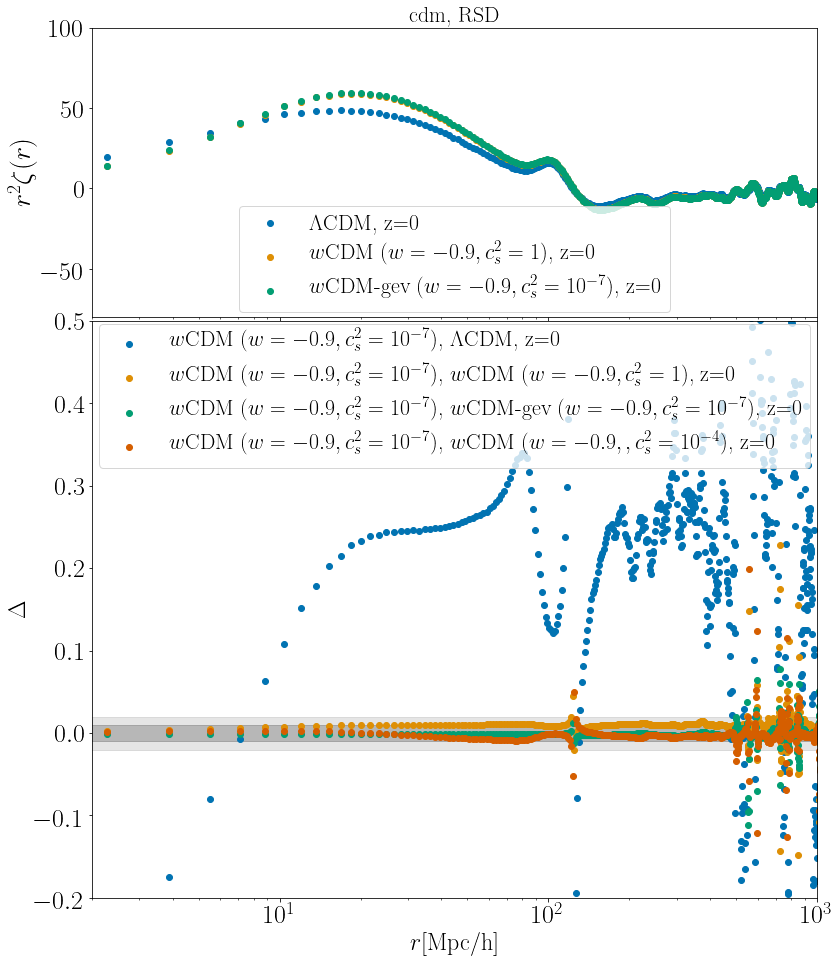

In [310]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-8.e1,1.e2)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.2], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(k1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.2,0.5)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.87], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo  Correlation function, noRSD

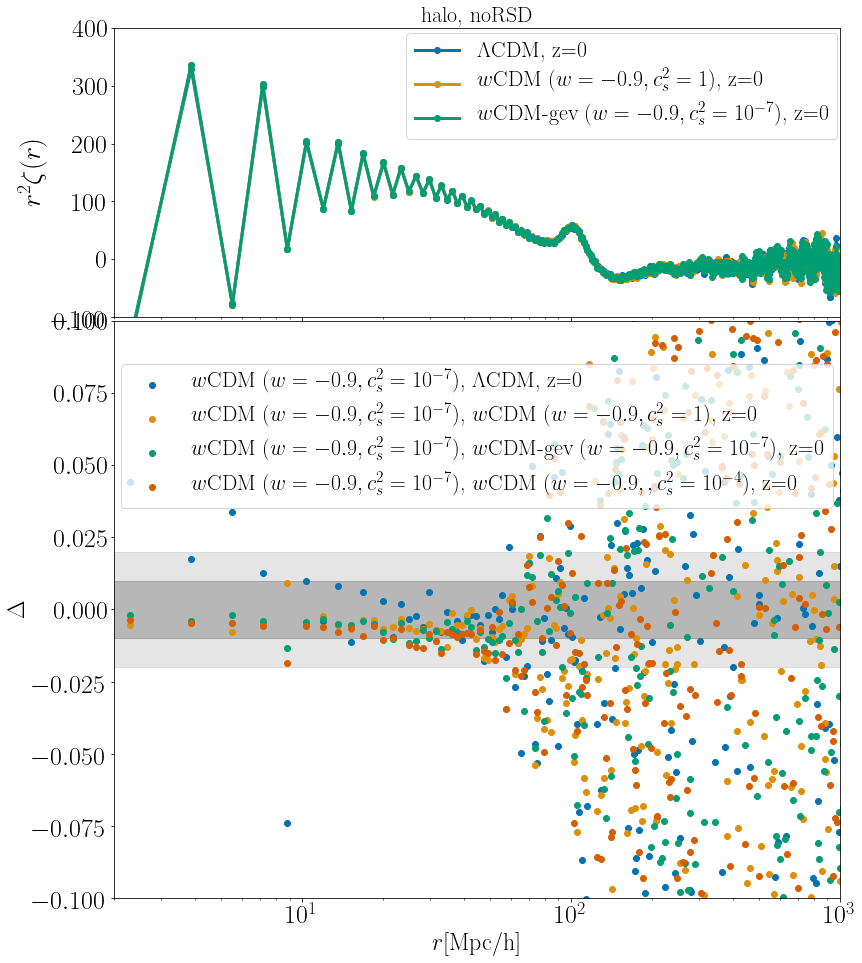

In [320]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='noRSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,400)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo  Correlation function, RSD

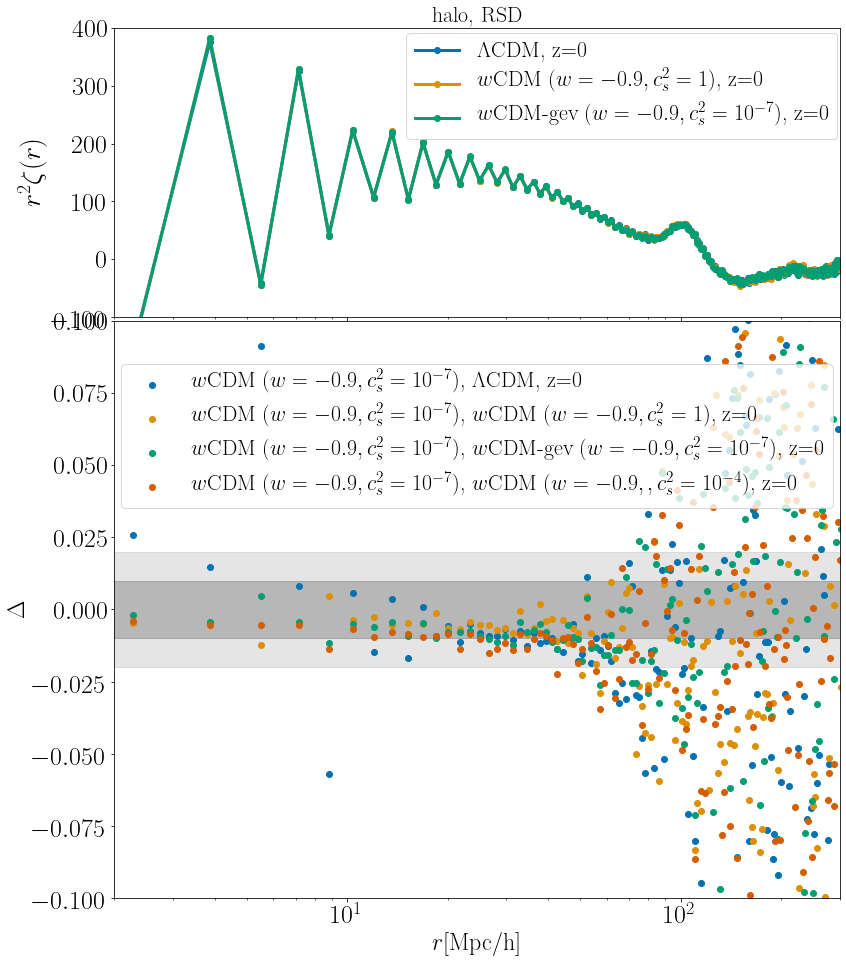

In [331]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,400)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,300)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# correlation function RSD, noRSD comparison

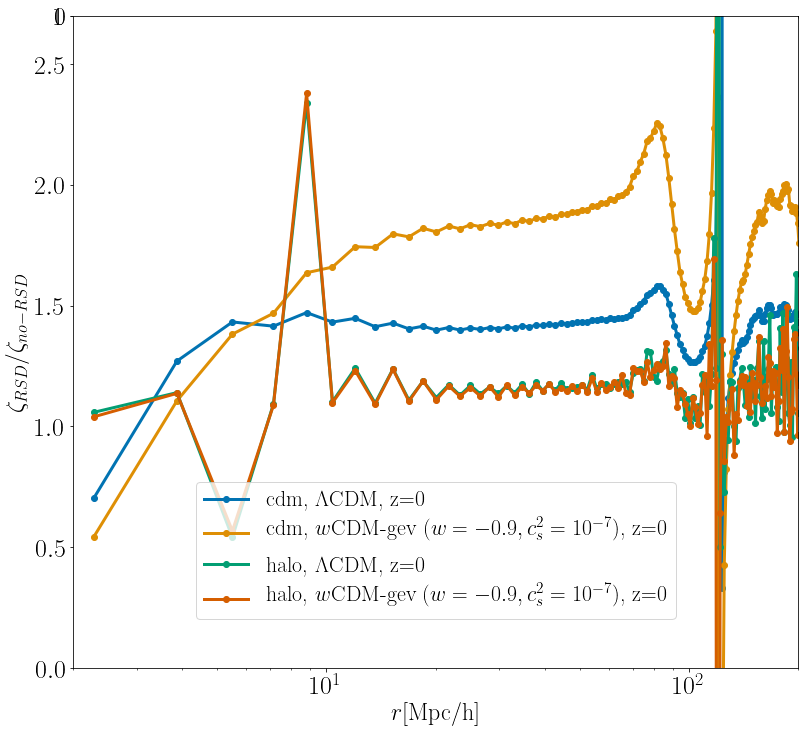

In [330]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
file_type = 'cor'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0,2]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]][file_type][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]][file_type][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"-o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [0,2]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]][file_type][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]][file_type][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"-o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$\zeta_{RSD}/\zeta_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0,2.7)
axs[1].set_xlim(2,200)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.18], loc='center')
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# quadrupole moment RSD, noRSD, halo

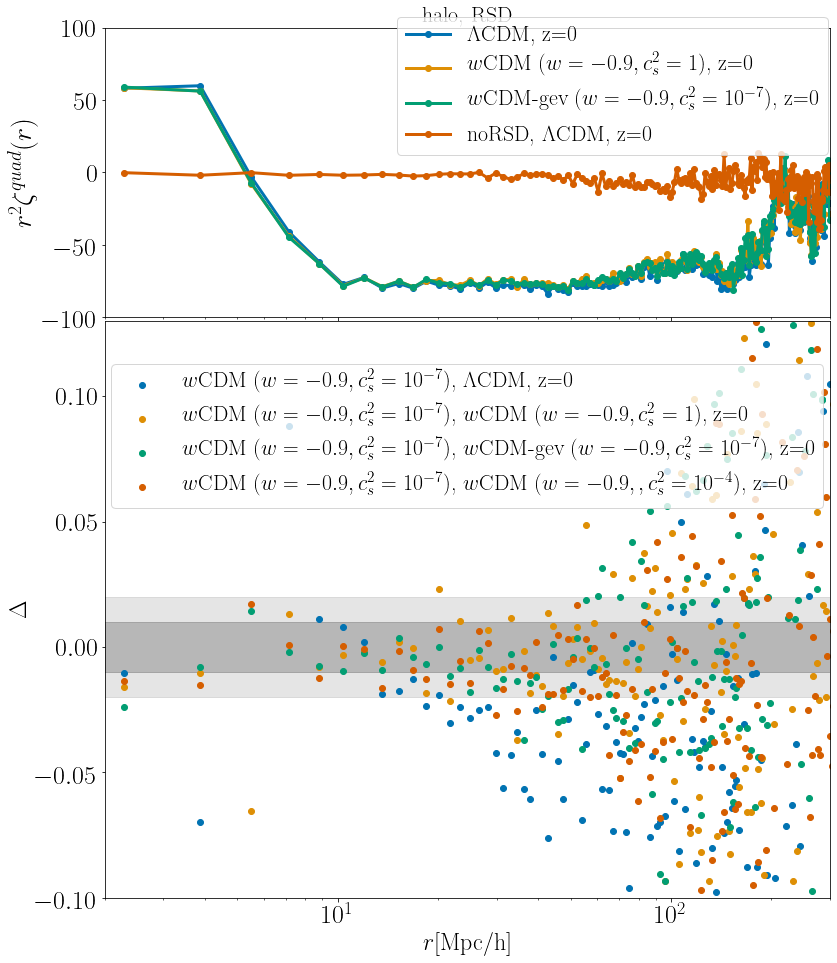

In [340]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1
        
for i in [0]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind]['noRSD'][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label="noRSD, "+decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta^{quad}(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,100)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,2],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,2],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.13)
axs[1].set_xlim(2,300)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# quadrupole moment RSD, noRSD, cdm

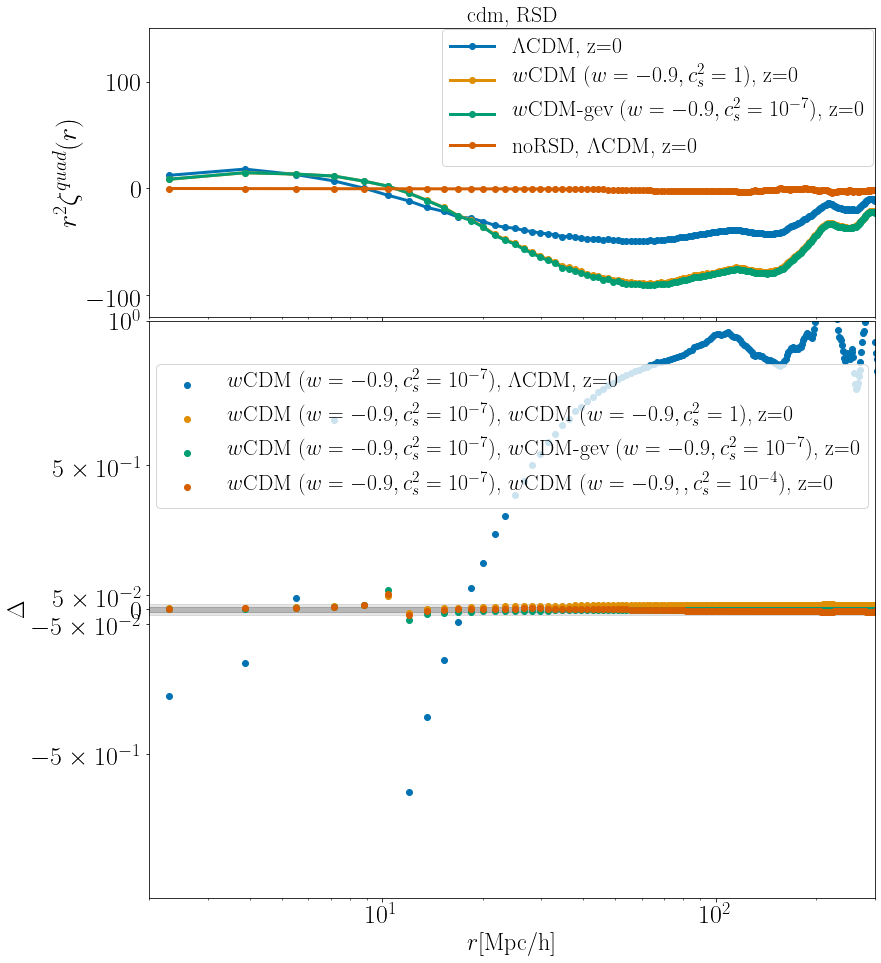

In [347]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1
        
for i in [0]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind]['noRSD'][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label="noRSD, "+decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta^{quad}(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-120,150)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.76], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,2],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,2],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
plt.yscale('symlog')
axs[1].set_ylim(-1,1)
axs[1].set_xlim(2,300)
axs[1].set_yticks([-0.5,-0.05,0,0.05,0.5,1])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
